<h1> TP 3: Hasting-Metropolis (and Gibbs) samplers 

Mélanie Pietri

**1.A - A population model for longitudinal data**

**1)** See Answers to theoretical questions

**2)** We choose reasonable values for the parameters.

In [1]:
# Librairies
import numpy as np 
import scipy 
import matplotlib.pyplot as plt
import random as rd
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import cm
import csv 
from scipy import stats
from scipy.stats import invwishart

# Use of LaTeX in graph
matplotlib.rcParams['text.usetex'] = True

# Improvement of the figure resolution
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

In [2]:
# Definition of dimensions N and K 
N = 10 # N = 10
K = 1000 # K = 100 

# Means and variances parameters 
p0_bar = 0
t0_bar = 0 
v0_bar = 1 

sigma_p0 = 2
sigma_t0 = 0.1
sigma_v0 = 0.1

p0 = 10

# Parameters to estimate theta
sigma = 0.1
sigma_xi = 0.1
sigma_tau = 0.1 
theta = [t0_bar, v0_bar, sigma_xi, sigma_tau, sigma]

# A priori on the parameters theta
t0_bar_bar, v0_bar_bar = 1,1
s_t0, s_v0 = 0.01, 0.01

# Inverse-Wishart parameters 
v_xi, v_tau, v = 1, 1, 1
m_xi, m_tau, m = 0.1, 0.1, 0.01

In [3]:
## Sampling of parameter theta
t0_bar = np.random.normal(t0_bar_bar,s_t0,1)
v0_bar = np.random.normal(v0_bar_bar,s_v0,1)
sigma_xi = invwishart.rvs(v_xi,m_xi,size=1)
sigma_tau = invwishart.rvs(v_tau,m_tau,size=1)
sigma = invwishart.rvs(v,m,size=1)

In [4]:
## Sampling of latent variable z 
t0 = np.random.normal(t0_bar,sigma_t0,1)
v0 = np.random.normal(v0_bar,sigma_v0, 1)
xi = np.random.normal(0,sigma_xi, N)
alpha = np.exp(xi)
tau = np.random.normal(0,sigma_tau,N)

z = (t0,v0,xi,tau)

In [5]:
# Average trajectory 
def d(t):
    return p0 + v0[0]*(t-t0[0])

# print(d(t))

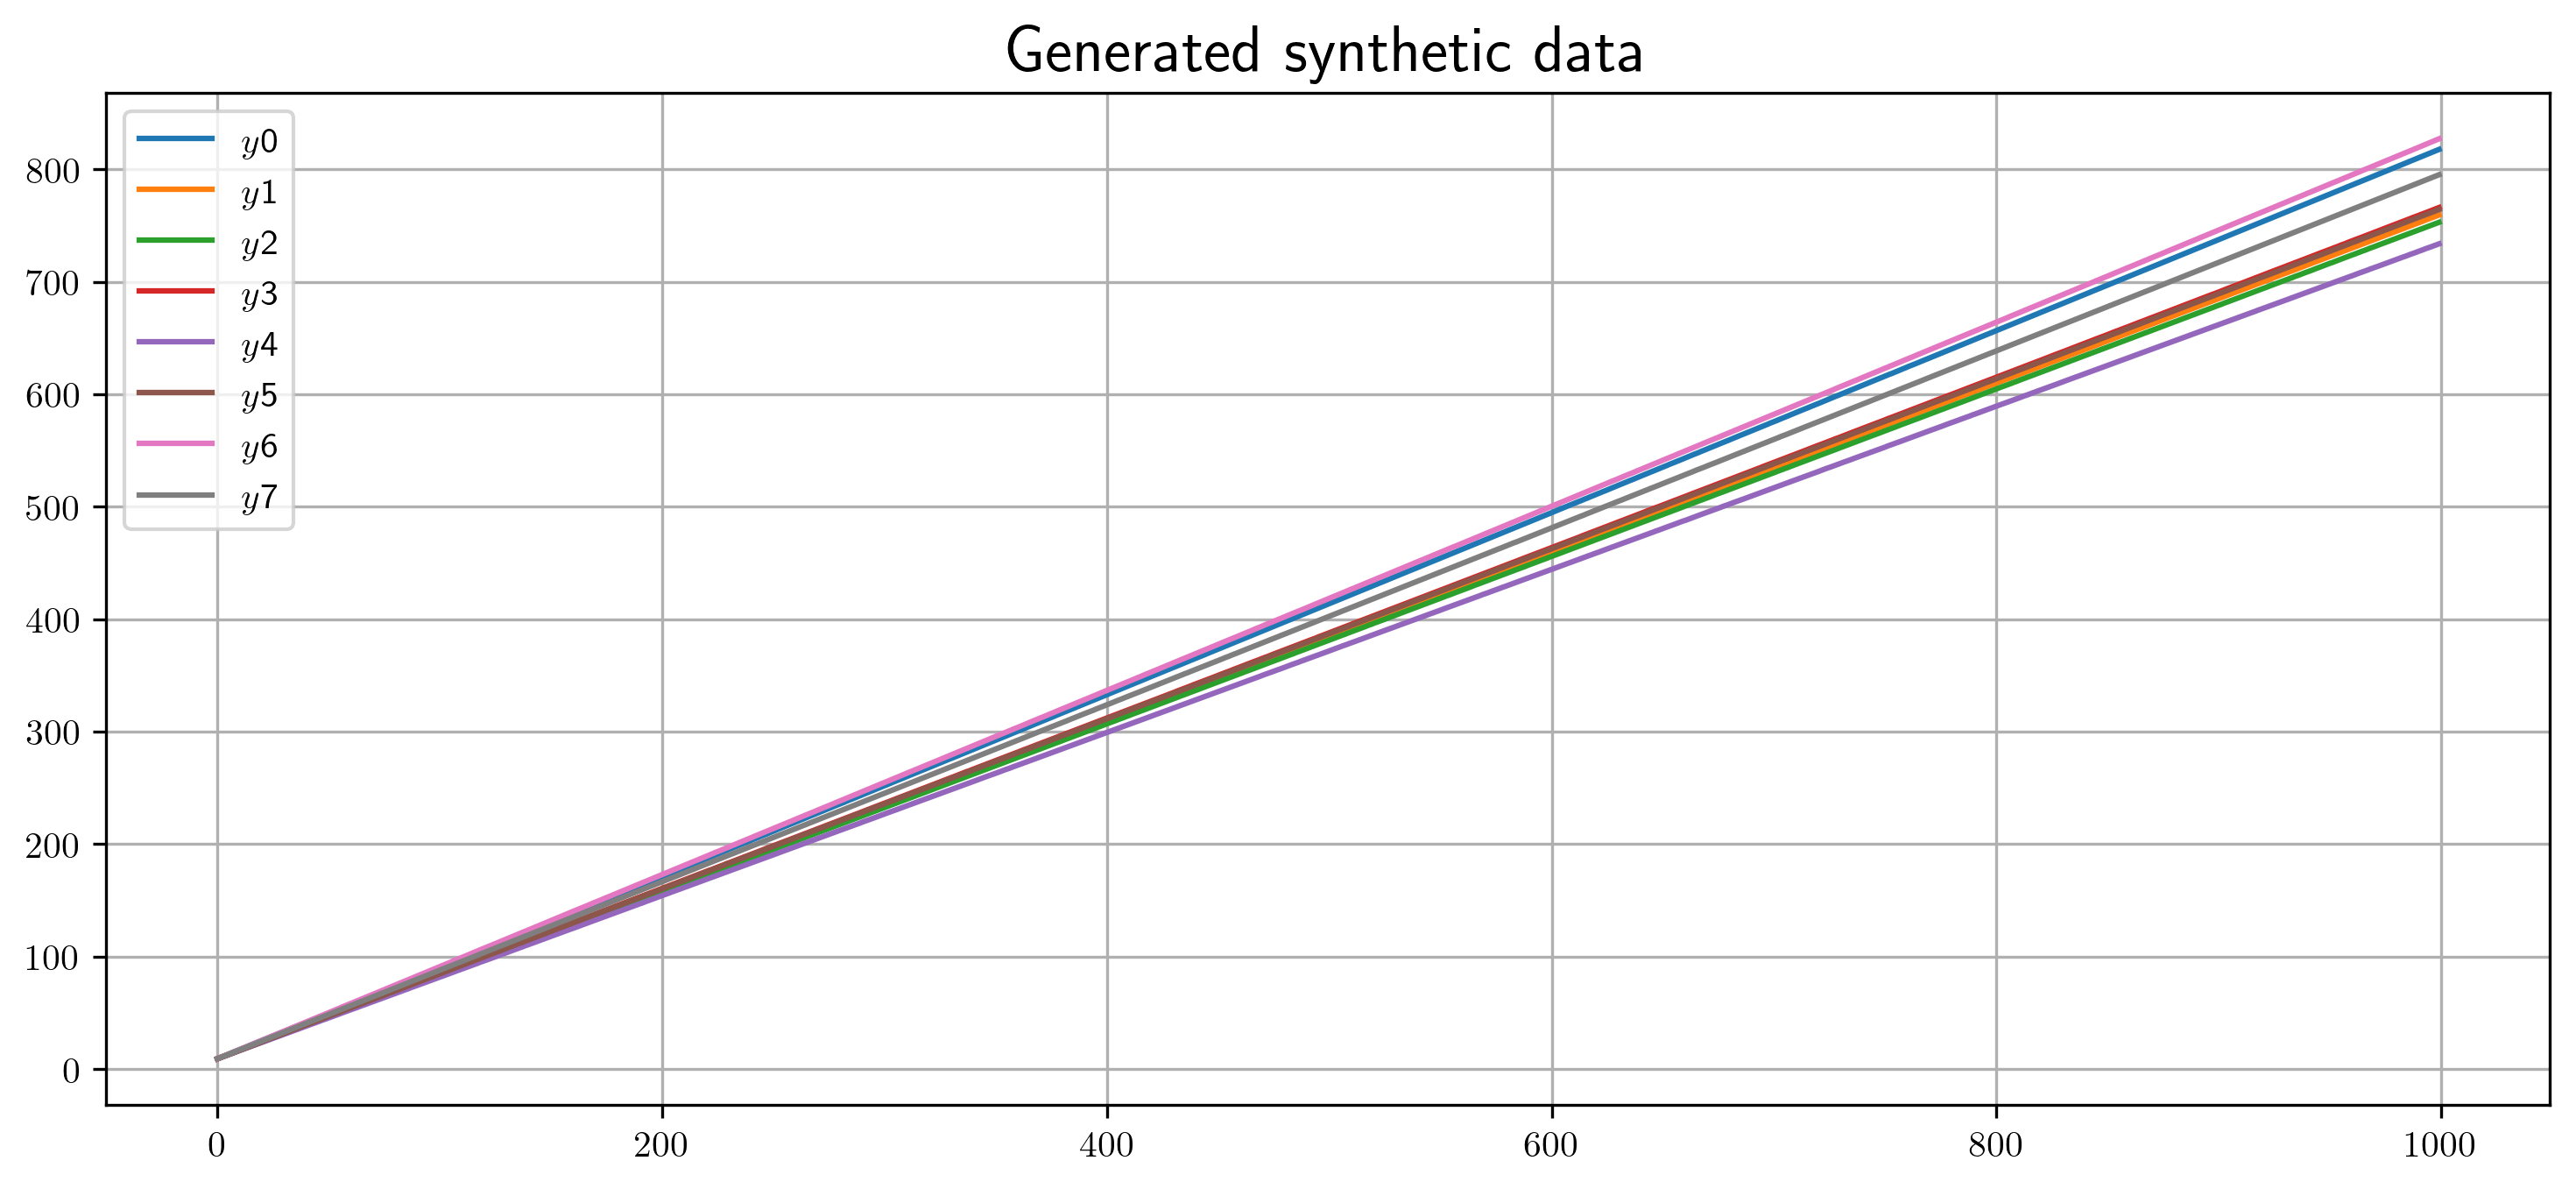

In [6]:
# Generation of synthetic data 
y = np.zeros((N,K)) # observations

for j in range(K):
    t = alpha*(j-t0-tau)
    epsilon = np.random.normal(0,sigma,N)
    y[:,j] = d(t+t0) + epsilon

# Plotting 8 lines 
plt.figure(figsize=(12,5))
for k in range(8):
    plt.plot(np.arange(K), y[k,:], label = '$y$'+str(k))
    
# Layout of the graph
plt.title('Generated synthetic data', fontsize=18)
plt.legend()
plt.grid()
plt.show() 

**1.B - HM-SAEM - Hasting-Metropolis sampler**

**3)** 

In [7]:
# Definition of useful function

t = np.arange(K).reshape(1, -1)

def S(y,z): # vector of coordinates S1, S2, S3, S4 or S5
    alpha = np.exp(xi)
    
    # Computation of S1
    S1 = ((y-d(t))**2).mean()
    
    # Computation of S2
    S2 = (xi**2).mean()
    
    # Computation of S3
    S3 = (tau**2).mean()
        
    # Computation of S4
    S4 = v0[0]
        
    # Computation of S5
    S5 = t0[0]
    
    return [S1, S2, S3, S4, S5]

def psi(theta):
    psi1 = - K*N/(sigma**2)
    psi2 = - N/(2*sigma_xi**2)
    psi3 = - N/(2*sigma_tau**2)
    psi4 = v0_bar/(sigma_v0**2)
    psi5 = t0_bar/(sigma_t0**2)
    return [psi1, psi2, psi3, psi4, psi5]

def phi1(z):
    (t0,v0,xi,tau) = z
    phi = -(m+3)*np.log(sigma*sigma_xi*sigma_tau)-(v**2)/(2*sigma**2)-(v**2)/(2*sigma_xi**2)-(v**2)/(2*sigma_tau**2)-(t0_bar**2)/(2*s_t0**2)-(v0_bar**2)/(2*s_v0**2)
    return phi

In [8]:
def log_posterior(z, sigma_xi_proposal,sigma_tau_proposal):
    t0, v0 = z[0:2]
    xi = z[2:N+2].reshape(-1, 1)
    tau = z[N+2:].reshape(-1, 1)
    
    ti = np.exp(xi)*(t-t0-tau)
    dz = np.sum((y-d(ti + t0))**2)
    pz = (np.sum(xi**2)/(2*sigma_xi_proposal**2) + np.sum(tau**2)/(2*sigma_tau_proposal**2) + (t0-t0_bar)**2 / (2*sigma_t0 ** 2) + (v0 - v0_bar)**2 / (2*sigma_v0 ** 2))
    return dz, pz

In [9]:
# Symmetric Random Walk Hasting-Metropolis algorithm
def SRWHM(z,y,maxIter):
    
    # Proposal of a gaussian distribution
    mean_proposition = [t0_bar, v0_bar] + (2*N)*[0]
    covariance_proposition = [sigma_t0, sigma_v0] + [sigma_xi]*N + [sigma_tau]*N
    covariance_proposition = 0.005*np.eye(2*N+2)*covariance_proposition
    
    Z = [z]
    
    for k in range(maxIter):
        # Proposal 
        zk = np.random.multivariate_normal(z,covariance_proposition) 
        dk, pk = log_posterior(zk,sigma_xi_proposal,sigma_tau_proposal) 
        d_current, p_current = log_posterior(z,sigma_xi_proposal,sigma_tau_proposal)

        # Acceptation / Rejection
        log_alpha = min(0,dk+pk-d_current-p_current) 
        log_uk = np.log(np.random.rand())
        if log_uk-log_alpha < 0: 
            z = zk.copy()
        Z.append(z) 
        
    return Z,log_alpha

# Checking SRWHM algorithm 
z = np.random.random(2*N+2)

# Proposal parameters
sigma_xi_proposal = 0.1 
sigma_tau_proposal = 0.1 

# Maximum number of iterations 
maxIter = 20000

# Estimation of the parameters
Z,log_alpha = SRWHM(z,y,maxIter)

Initialization of t0:  0.17972502529165935
t0_bar targetted:  1.0132203733876852
 
Initialization of v0:  0.45888330001534505
v0_bar targetted:  1.0131854565629719


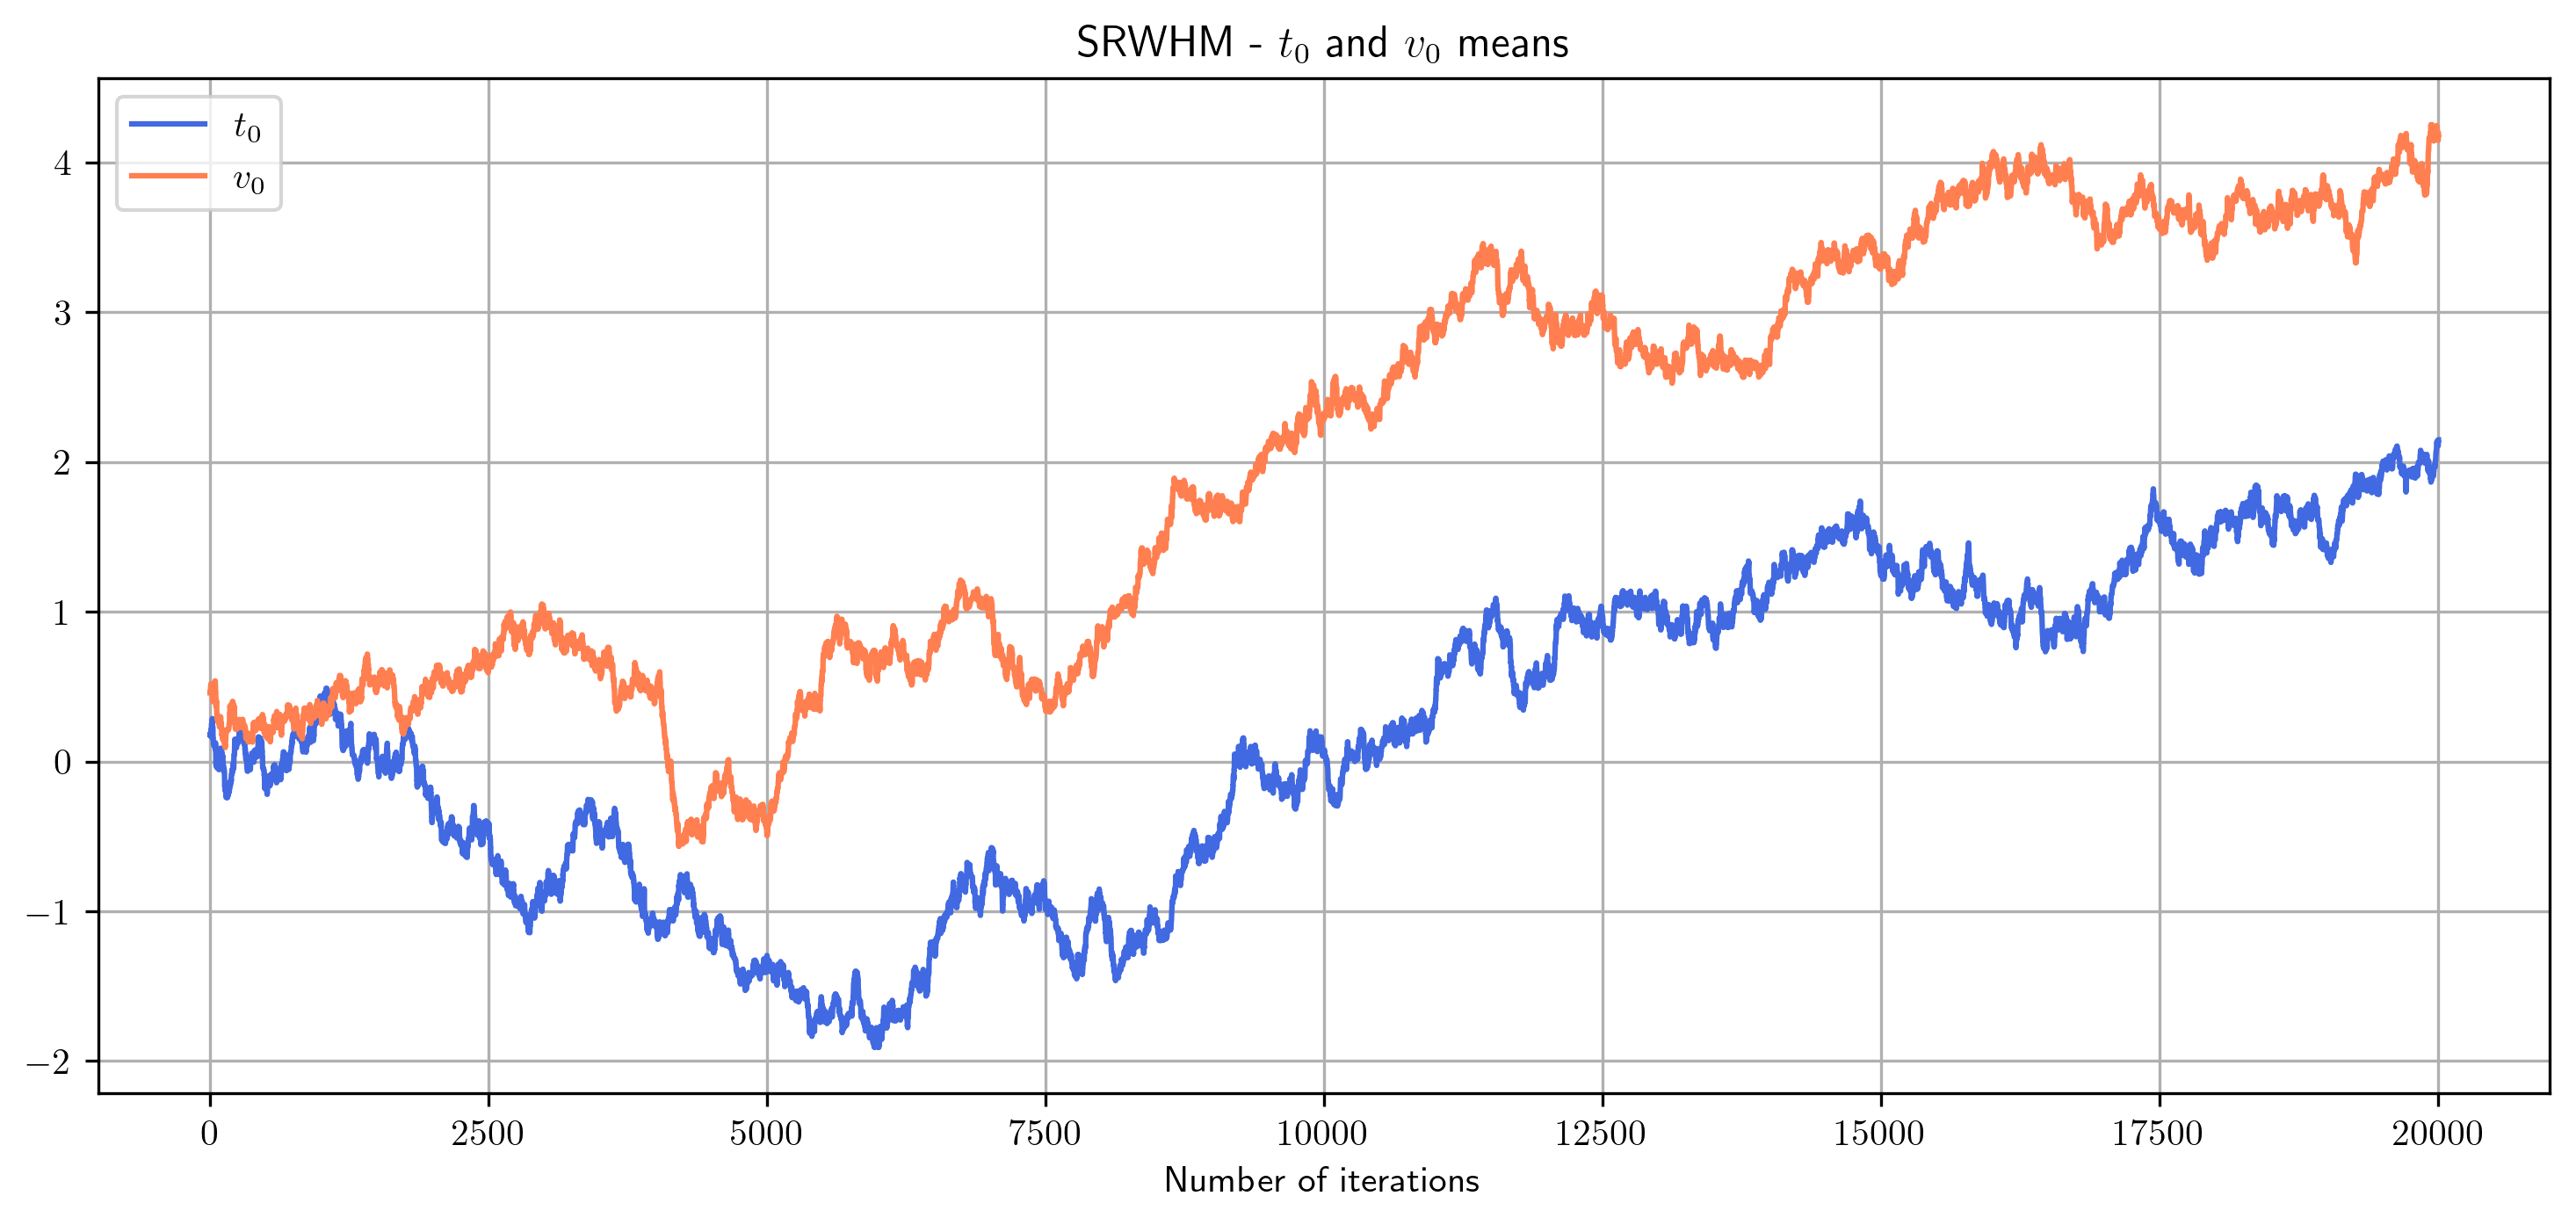

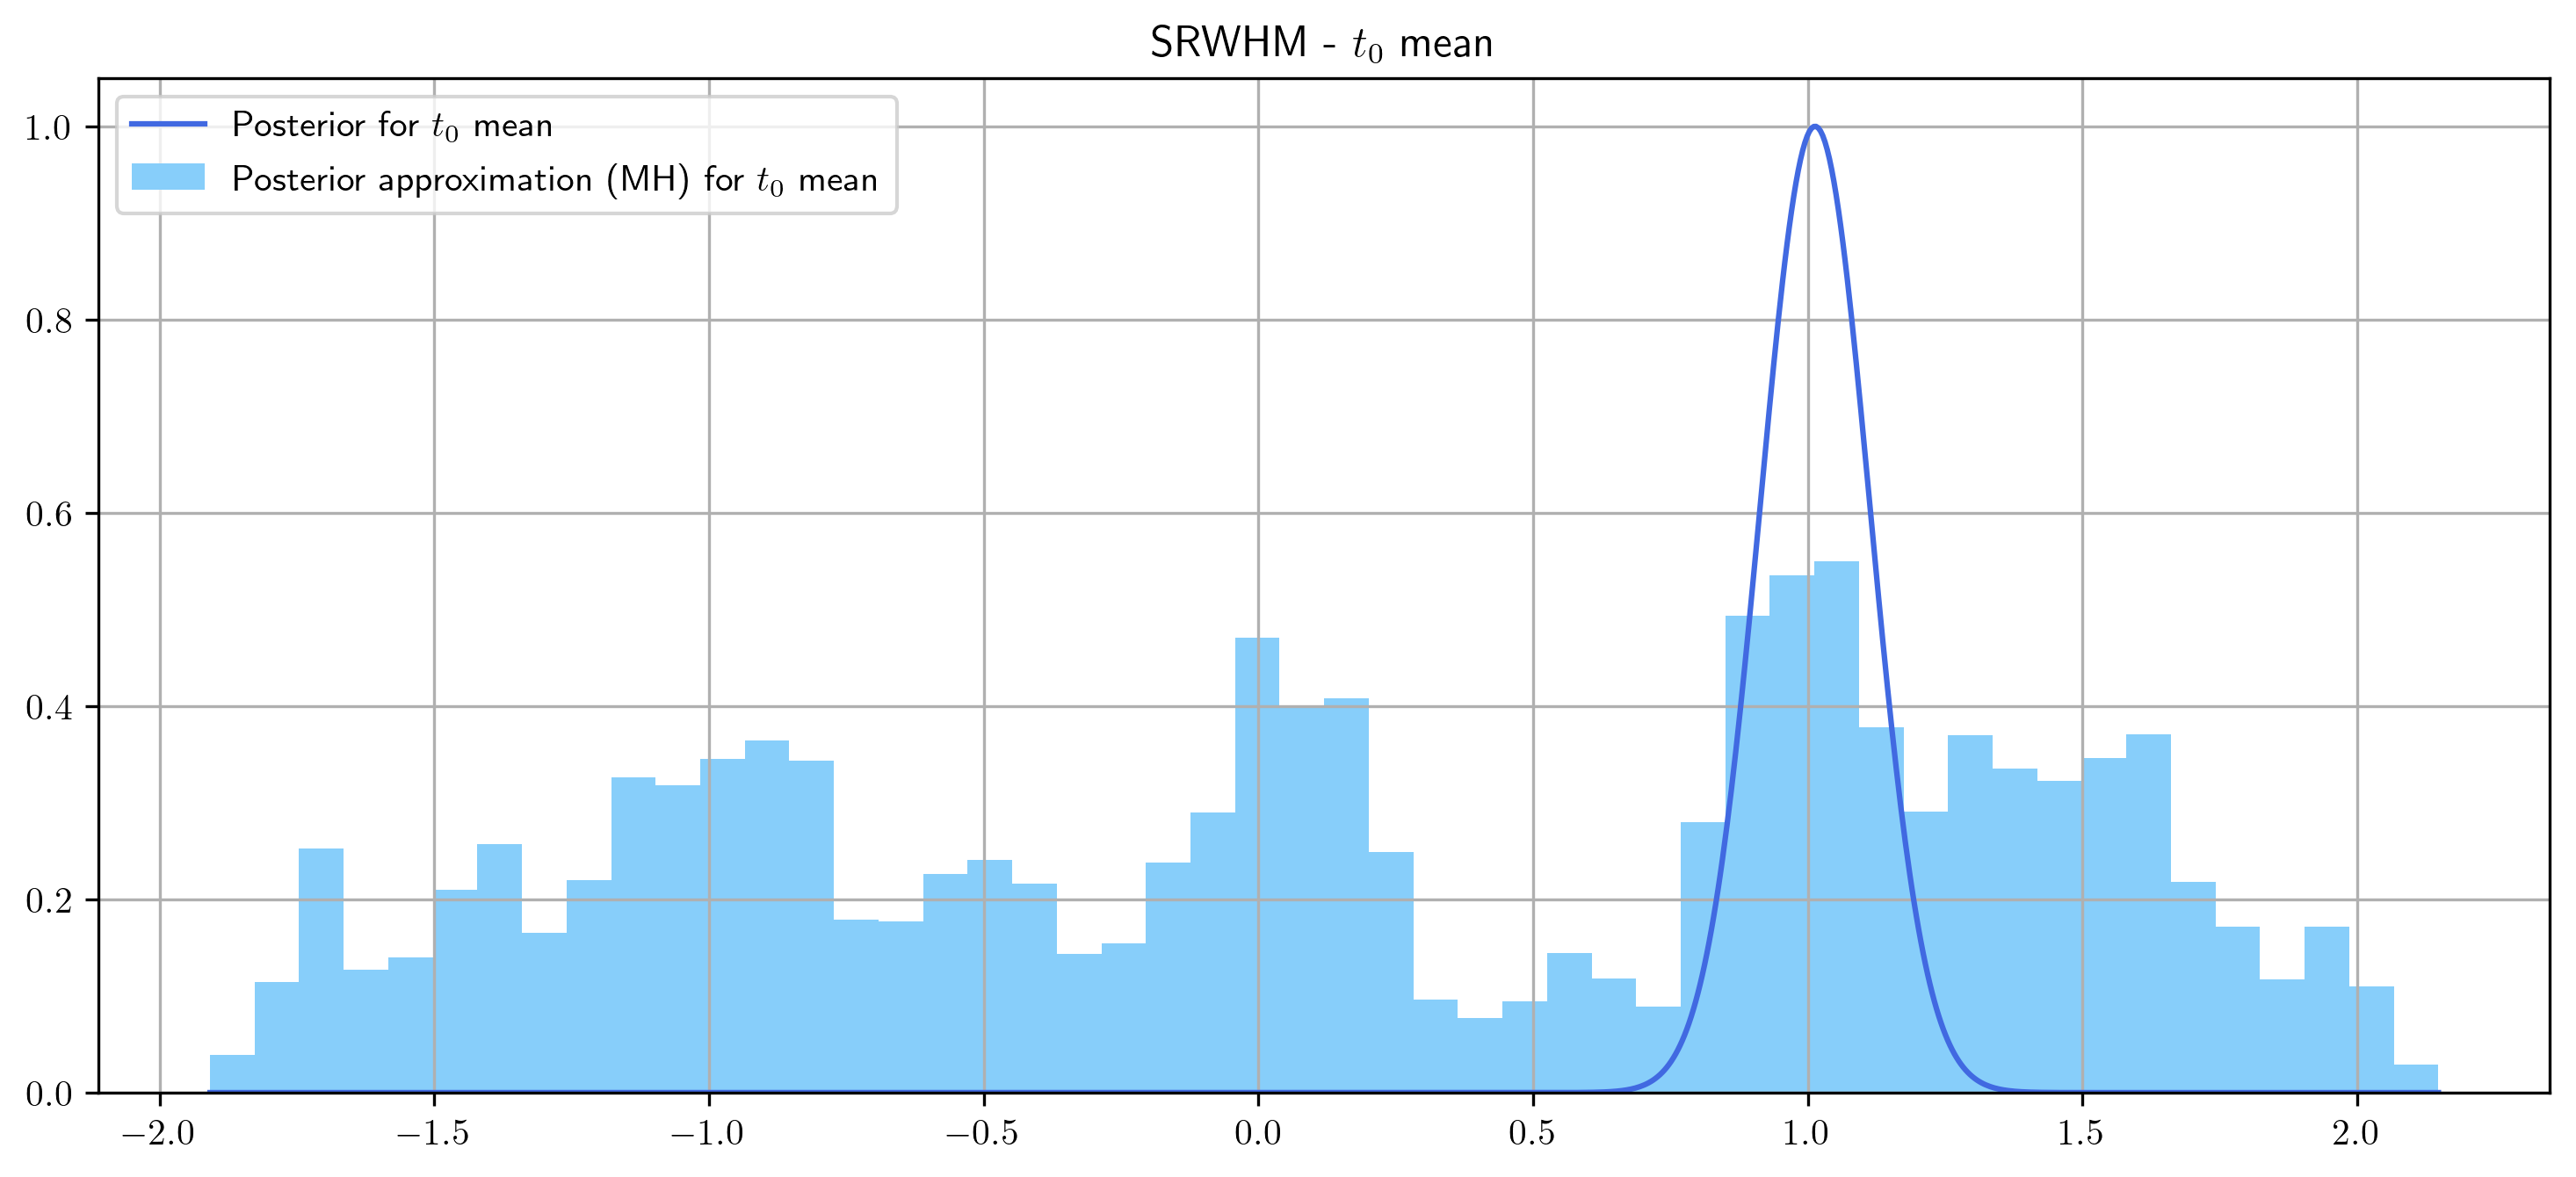

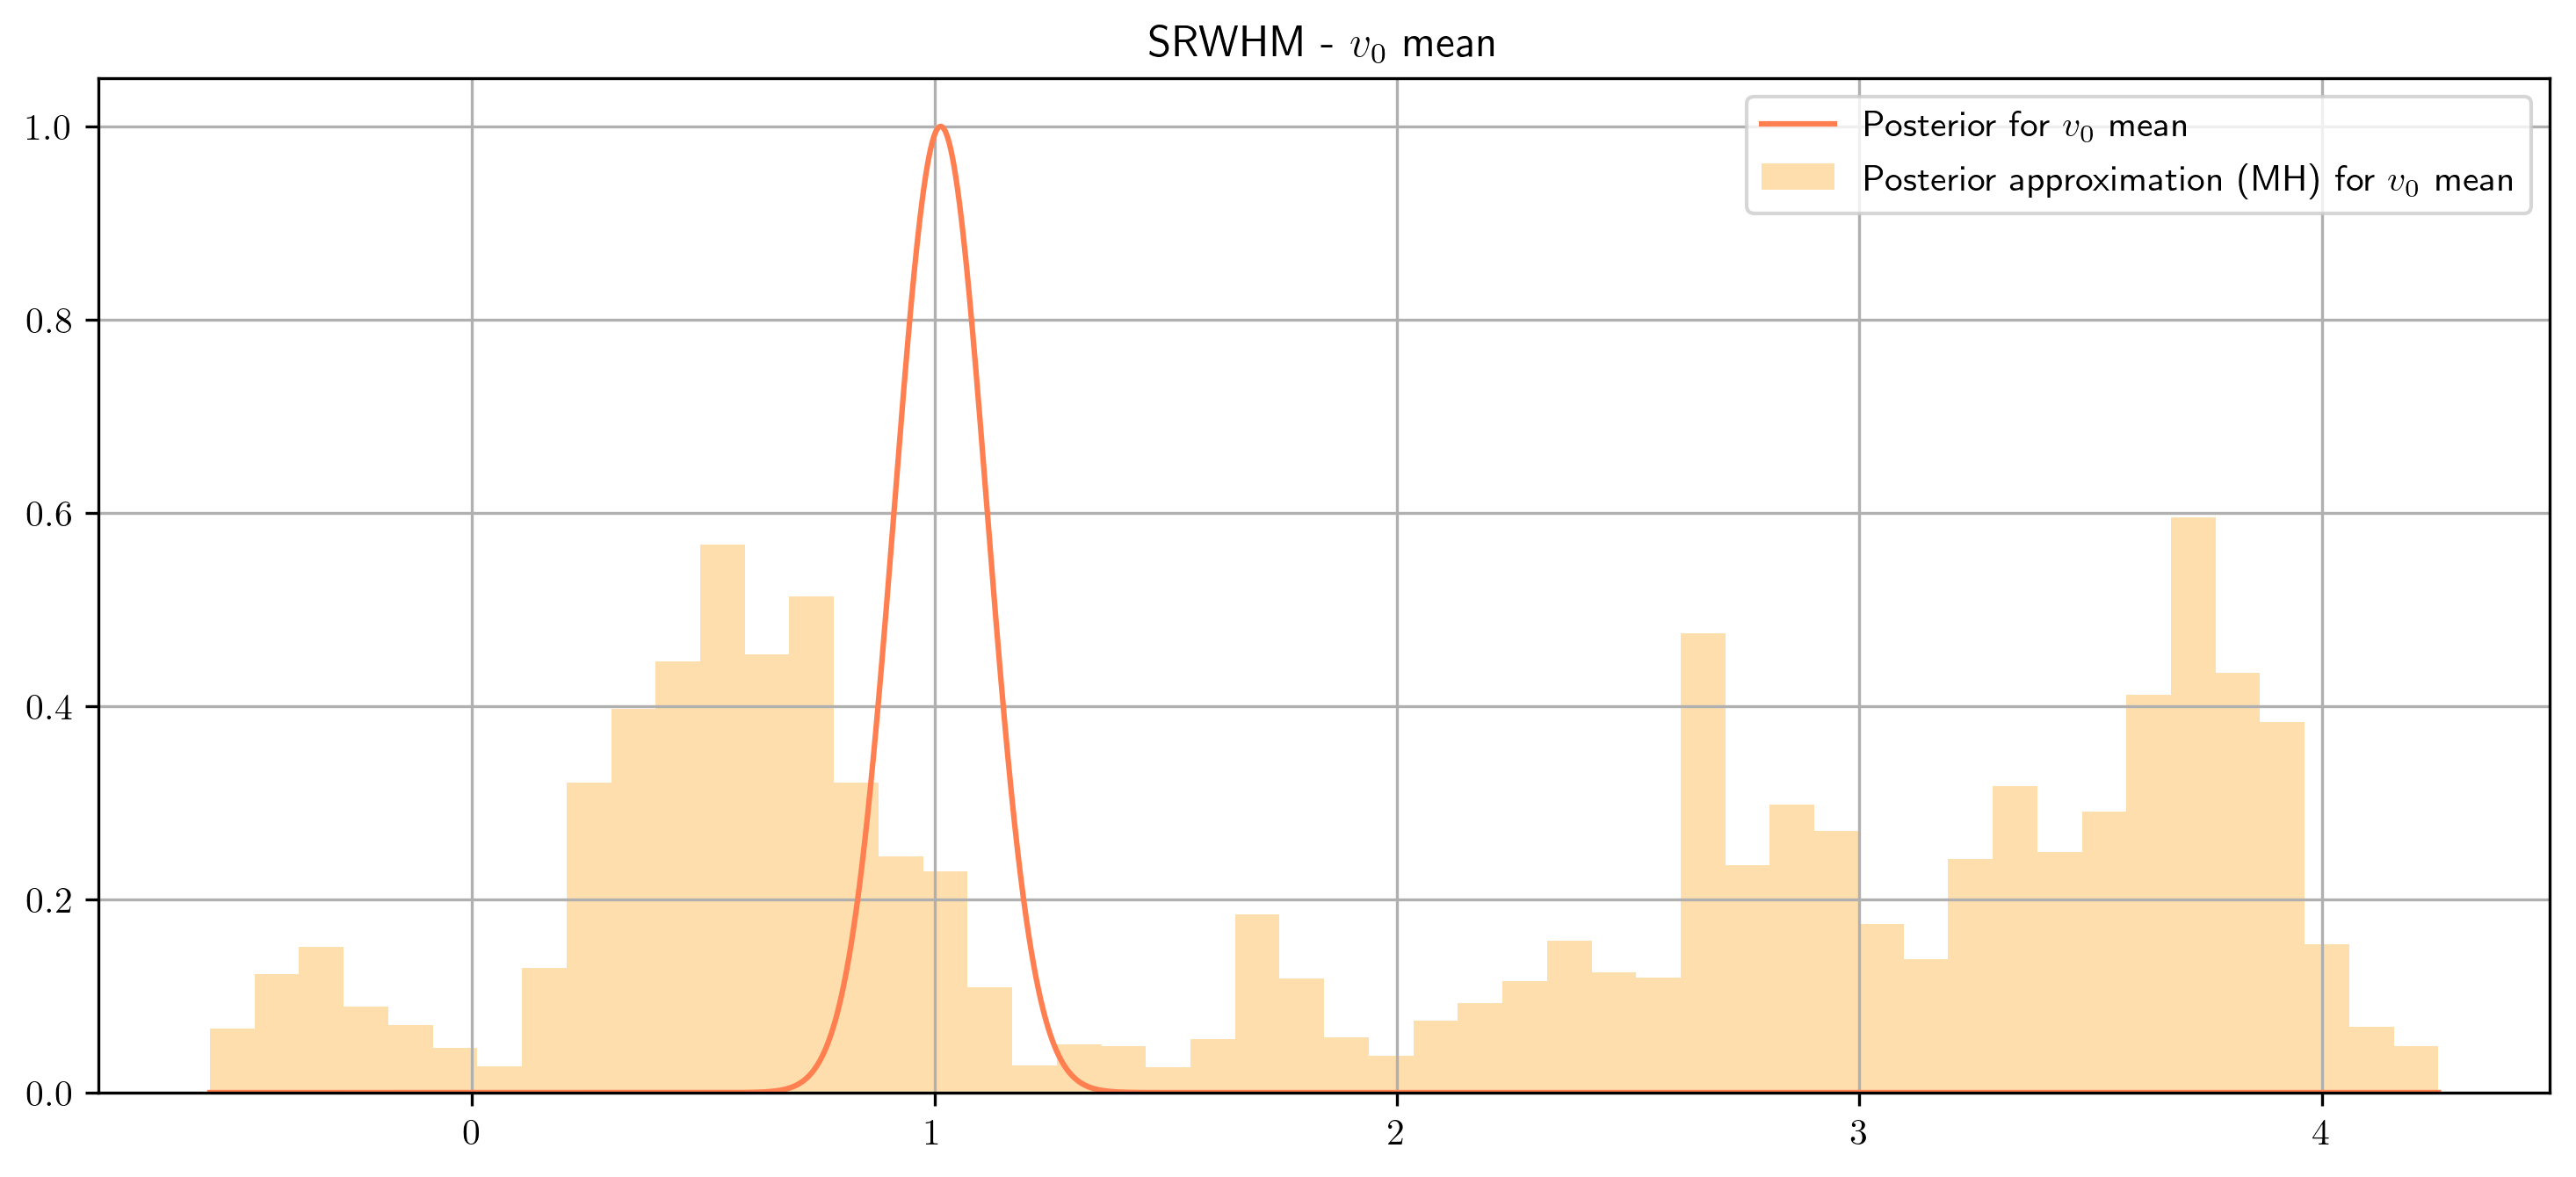

In [10]:
# t0
t0_list = [Z[i][0] for i in range(len(Z))]
print('Initialization of t0: ', t0_list[0])
print('t0_bar targetted: ', t0_bar[0])
print(' ')
x_t0 = np.linspace(min(t0_list),max(t0_list),1000)
y_t0 = np.asarray([stats.norm.pdf(x, loc=t0_bar, scale=sigma_t0) for x in x_t0])

# v0
v0_list = [Z[i][1] for i in range(len(Z))]
print('Initialization of v0: ', v0_list[0])
print('v0_bar targetted: ', v0_bar[0])
x_v0 = np.linspace(min(v0_list),max(v0_list),10000)
y_v0 = np.asarray([stats.norm.pdf(x, loc=v0_bar, scale=sigma_v0) for x in x_v0])

# Layout of the graph
# Plot for t0 and v0
plt.figure(figsize=(12,5))
plt.plot(t0_list, label ='$t_{0}$', color ='royalblue')
plt.plot(v0_list, label ='$v_{0}$', color ='coral')
plt.title("SRWHM - $t_{0}$ and $v_{0}$ means") 
plt.xlabel('Number of iterations')
plt.legend()
plt.grid()

# Plot for SRWHM on t0
plt.figure(figsize=(12,5))
plt.plot(x_t0, y_t0/max(y_t0), label = " Posterior for $t_{0}$ mean ", color = 'royalblue')
plt.hist(t0_list, bins=50, density=True, label="Posterior approximation (MH) for $t_{0}$ mean", color = 'lightskyblue') 
plt.title("SRWHM - $t_{0}$ mean") 
plt.legend()
plt.grid()
plt.show()

# Plot for SRWHM on v0
plt.figure(figsize=(12,5))
plt.plot(x_v0, y_v0/max(y_v0), label = " Posterior for $v_{0}$ mean ", color = 'coral')
plt.hist(v0_list, bins=50, density=True, label="Posterior approximation (MH) for $v_{0}$ mean", color = 'navajowhite') 
plt.title("SRWHM - $v_{0}$ mean") 
plt.legend()
plt.grid()
plt.show()

**4)** See Answers to theoretical questions. The implementation of MCMC-SAEM is made below.

In [11]:
def MCMC_SAEM(y,z,alpha,nb_max,maxIter):
    S0 = np.array([0,0,0,0,0])
    
    for k in range(maxIter):
        if k <= nb_max:
            epsilon = 1
        else: 
            epsilon = (k-nb_max)**(-alpha)
    
        Z = SRWHM(z,y,maxIter)[0]
        Z = Z[-1]
    
        # Stochastic approximation 
        S0 = S0 + epsilon*(S(y,Z)-S0)
    
        # Update 
        t0 = (S0[4]/sigma_t0**2)+(t0_bar_bar/s_t0**2)/(1/sigma_t0**2+1/s_t0**2) 
        v0 = (S0[3]/sigma_v0**2)+(v0_bar_bar/s_v0**2)/(1/sigma_v0**2+1/s_v0**2) 
        sigma_xi = np.sqrt((N*S0[1])/(N+m_xi+2))
        sigma_tau = np.sqrt((N*S0[2])/(N+m_tau+2))
        sigma = np.sqrt(K*N*S0[0]/(N*K+m+2))
    
        # Maximization 
        theta = t0,v0,sigma_xi,sigma_tau,sigma
    
    return theta

theta = MCMC_SAEM(y,z,0.5,15,maxIter)
print('Optimal parameters: ', theta)

KeyboardInterrupt: 

**1.C - HMwG-SAEM - Hasting-Metropolis within Gibbs sampler**

**8)** See Answers to theoretical questions

<h2>Exercise 2: Multiplicative Hasting-Metropolis

**1)** See Answers to theoretical questions

**2)** See Answers to theoretical questions

**3)** We can use a uniform distribution on $]-1,1[$

In [12]:
# Uniform distribution on ]-1,1[
def uniform():
    return np.random.rand()*2-1

# Gaussian distribution of mean 0 and variance 1
def gaussian(x):
    return np.exp(-0.5*x**2) / np.sqrt(2*np.pi)

def Hasting_Metropolis(nb_step):
    X = uniform() 
    # X = np.random.normal(0,1) 
    
    for k in range(nb_step):
        epsilon = uniform()
        
        # Value of Y
        B = np.round(np.random.rand())
        if B == 1:
            Y = epsilon*X
        else:
            Y = X/epsilon

        # Computation of alpha
        alpha = min(1,(gaussian(Y)/gaussian(X))*(abs(Y)/abs(X)))
        
        if np.random.rand() < alpha:
            X = Y
    return X

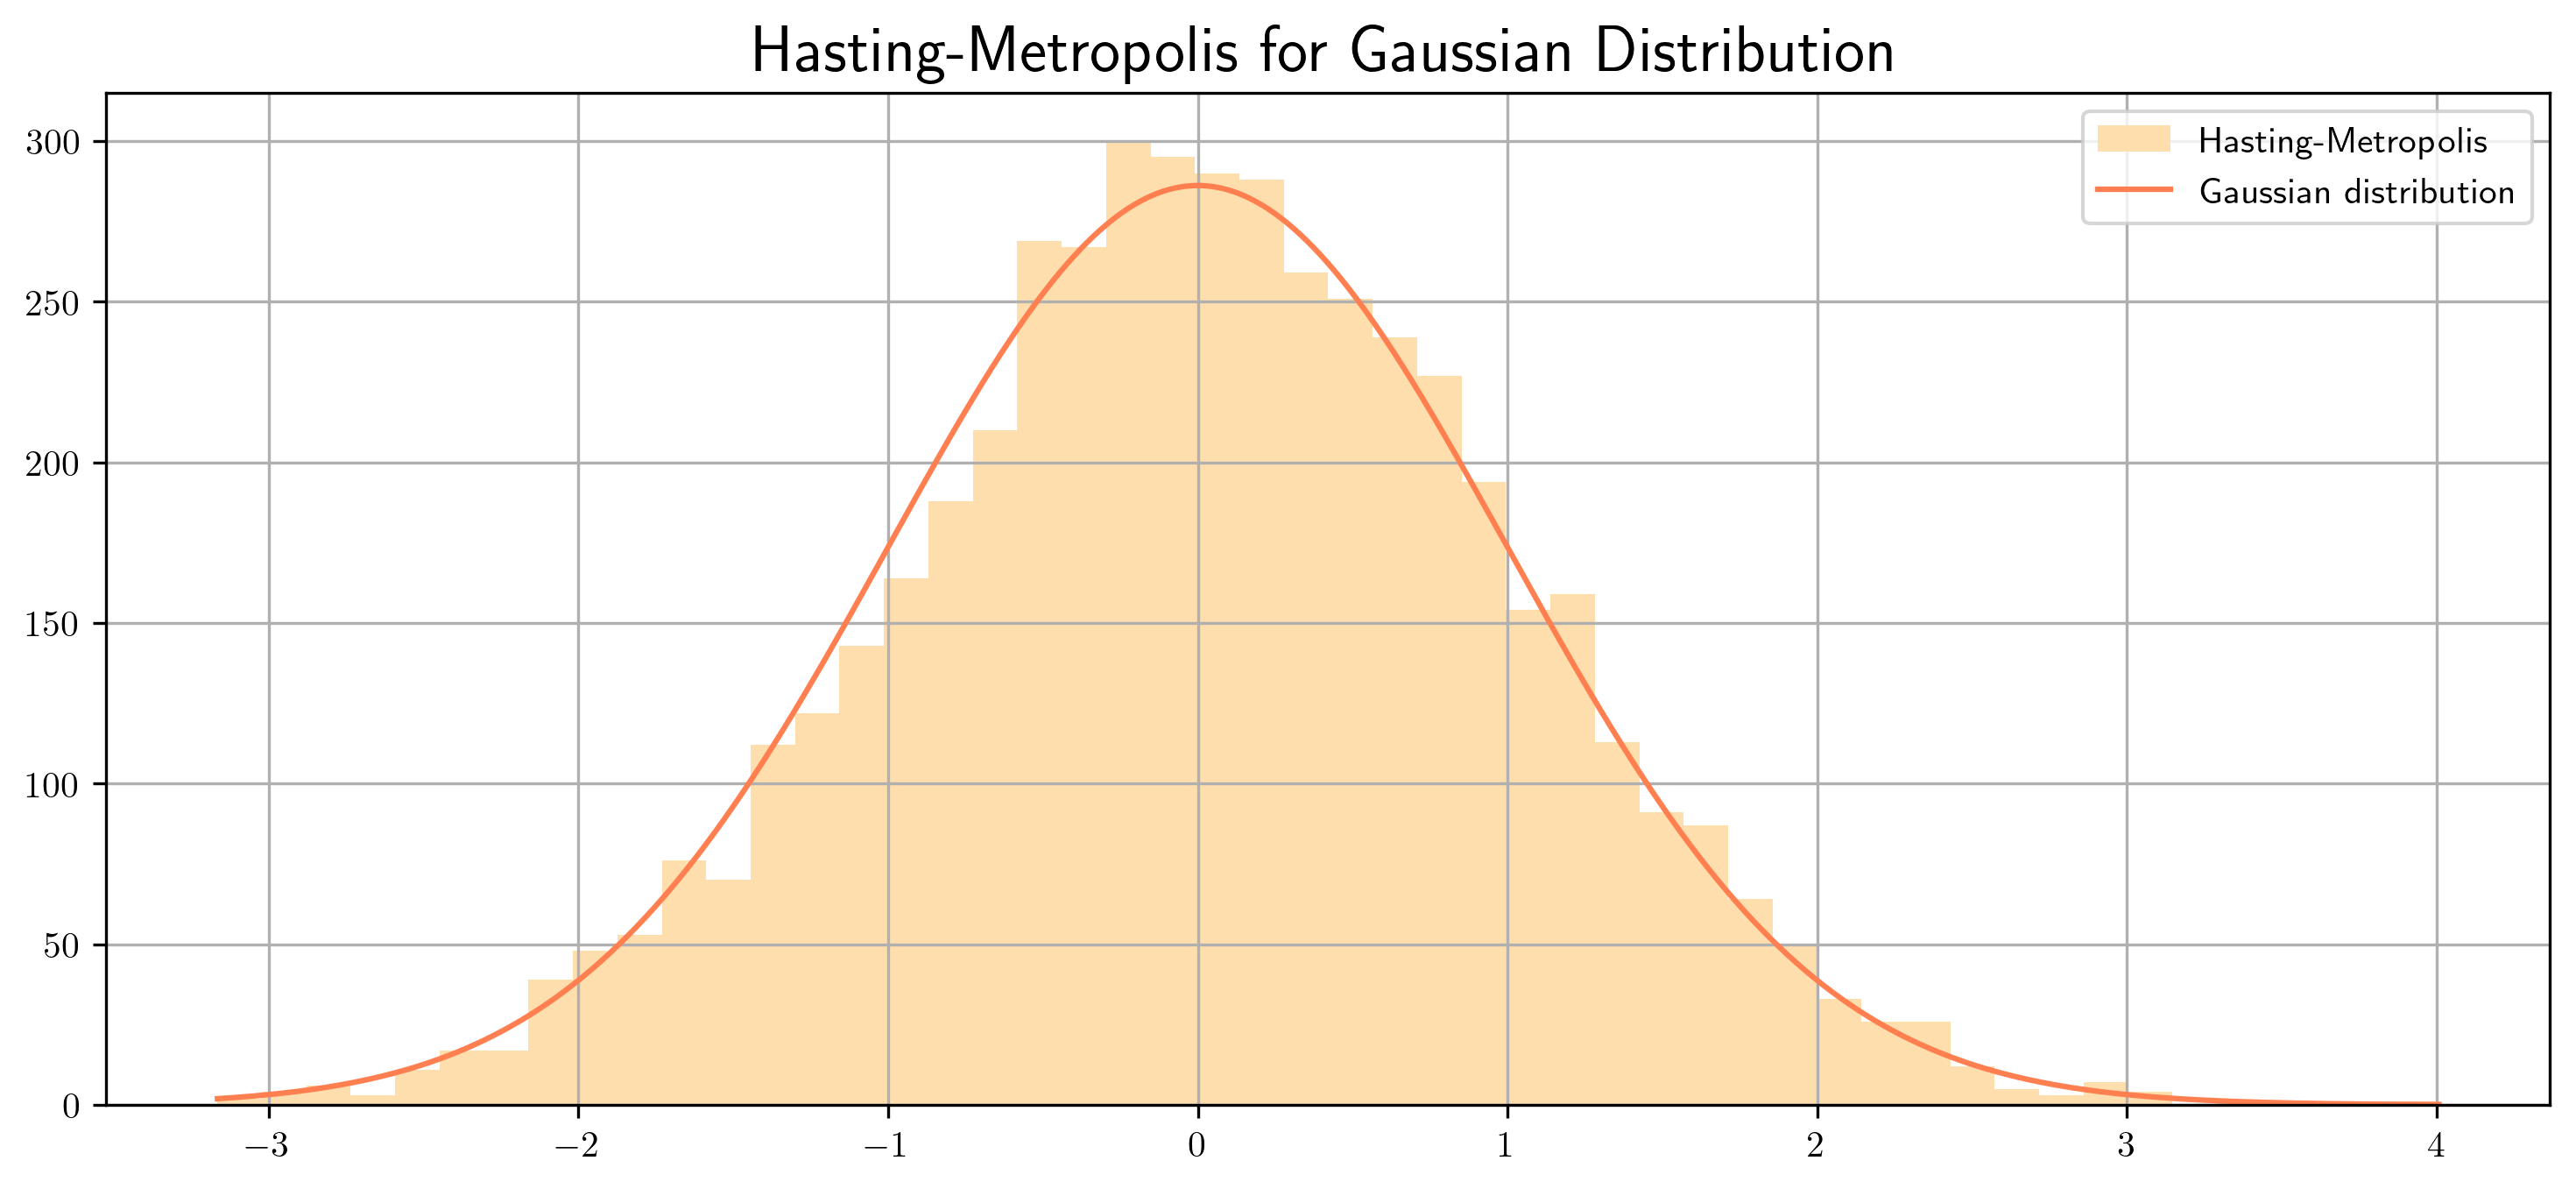

In [13]:
N = 5000
X = [Hasting_Metropolis(100) for k in range(N)]
x = np.linspace(min(X),max(X),1000)
gaussian_distribution = gaussian(x)*100*(max(X)-min(X))

plt.figure(figsize=(12,5))
plt.hist(X, 50, color = 'navajowhite',label = 'Hasting-Metropolis')
plt.plot(x,gaussian_distribution, color = 'coral', label = 'Gaussian distribution')

# Layout of the graph
plt.title('Hasting-Metropolis for Gaussian Distribution', fontsize=18)
plt.legend()
plt.grid()
plt.show() 